# **Online Fraud Payment Detection**

> # **Introduction**

With the rapid growth of e-commerce and online transactions, the need for robust security measures to combat fraudulent activities has become paramount. The "Online Fraud Payment Detection" project addresses this critical concern by leveraging advanced data science techniques to identify and prevent fraudulent transactions in real-time.

As online payment platforms continue to evolve, so do the methods employed by fraudsters to exploit vulnerabilities. This project aims to develop a sophisticated predictive model that can analyze transactional data, detect irregular patterns, and provide instantaneous alerts to mitigate potential risks. By combining cutting-edge machine learning algorithms with comprehensive data analysis, the goal is to create a proactive defense system that safeguards both businesses and consumers from financial fraud.

The dataset consists of 10 variables:

* step: represents a unit of time where 1 step equals 1 hour
* type: type of online transaction
* amount: the amount of the transaction
* nameOrig: customer starting the transaction
* oldbalanceOrg: balance before the transaction
* newbalanceOrig: balance after the transaction
* nameDest: recipient of the transaction
* oldbalanceDest: initial balance of recipient before the transaction
* newbalanceDest: the new balance of recipient after the transaction
* isFraud: fraud transaction

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
from tabulate import tabulate
import random
import tensorflow as tf

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv
/kaggle/input/fraud-detection/__results__.html
/kaggle/input/fraud-detection/__notebook__.ipynb
/kaggle/input/fraud-detection/__output__.json
/kaggle/input/fraud-detection/custom.css
/kaggle/input/fraud-detection/__results___files/__results___20_1.png
/kaggle/input/fraud-detection/__results___files/__results___9_0.png
/kaggle/input/fraud-detection/__results___files/__results___31_0.png
/kaggle/input/fraud-detection/__results___files/__results___22_1.png
/kaggle/input/fraud-detection/catboost_info/test_error.tsv
/kaggle/input/fraud-detection/catboost_info/learn_error.tsv
/kaggle/input/fraud-detection/catboost_info/catboost_training.json
/kaggle/input/fraud-detection/catboost_info/time_left.tsv
/kaggle/input/fraud-detection/catboost_info/learn/events.out.tfevents
/kaggle/input/fraud-detection/catboost_info/test/events.out.tfevents


> # **Exploratory Data Analysis**

In [4]:
df = pd.read_csv('/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv')
df.drop('isFlaggedFraud', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


In [5]:
print('Number of observations in the dataset = ')
print(len(df))

Number of observations in the dataset = 
6362620


In [6]:
df.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2260482,187,CASH_OUT,142668.98,C1703664566,0.00,0.00,C1928882606,8426191.94,8568860.92,0
4476651,324,PAYMENT,24255.91,C1696073309,0.00,0.00,M638156905,0.00,0.00,0
2965861,231,CASH_IN,287329.99,C928852481,2350061.66,2637391.65,C616841905,1774629.04,1487299.05,0
1653605,158,PAYMENT,17453.78,C1308327759,0.00,0.00,M589134640,0.00,0.00,0
5189981,369,CASH_OUT,271963.50,C1274130640,19942.00,0.00,C991782278,3720683.79,3992647.28,0


In [7]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64


* There are no missing values.

In [8]:
fraud_min_max = [
    ['amount', df.amount.min(), df.amount.max()],
    ['oldbalanceOrg', df.oldbalanceOrg.min(), df.oldbalanceOrg.max()],
    ['newbalanceOrig', df.newbalanceOrig.min(), df.newbalanceOrig.max()],
    ['oldbalanceDest', df.oldbalanceDest.min(), df.oldbalanceDest.max()],
    ['isFraud', df.isFraud.min(), df.isFraud.max()]
] 

print(
    tabulate(
        fraud_min_max,
        headers=['columns', 'min value', 'max value'],
        showindex=True,
        tablefmt='github',
        numalign='right'
    )
)

|    | columns        |   min value |   max value |
|----|----------------|-------------|-------------|
|  0 | amount         |           0 | 9.24455e+07 |
|  1 | oldbalanceOrg  |           0 |  5.9585e+07 |
|  2 | newbalanceOrig |           0 |  4.9585e+07 |
|  3 | oldbalanceDest |           0 | 3.56016e+08 |
|  4 | isFraud        |           0 |           1 |


In [9]:
# Downcast numerical columns with smaller dtype
for col in df.columns:
    if df[col].dtype == 'float64':
        df[col] = pd.to_numeric(df[col], downcast='float')
    if df[col].dtype == 'int64':
        df[col] = pd.to_numeric(df[col], downcast='unsigned')

# Use category dtype for categorical column
df['type'] = df['type'].astype('category')

In [10]:
# Check duplicate values
df.duplicated().sum()

0

* There are no duplicate values.

In [11]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (8,6)

> #   **Univariate data visualization**

In [12]:
df['step'].value_counts()

step
19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
432        4
706        4
693        4
112        2
662        2
Name: count, Length: 743, dtype: int64

* There are 743 steps, and every step has at least 2 occurrences.

Text(0, 0.5, 'Number of transactions')

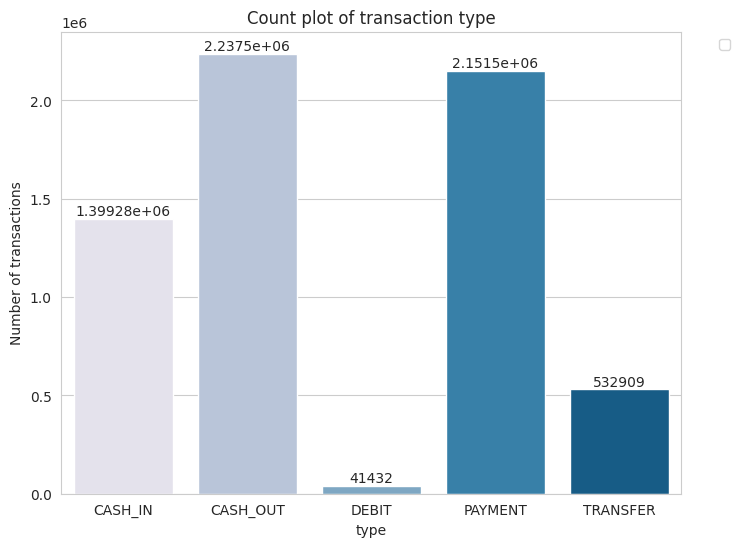

In [13]:
ax = sns.countplot(x='type', data=df, palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of transaction type')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')

* **Cash out** is the **most numerous transaction** type, followed by payment, cash in, transfer and debit types.

Text(0.5, 1.0, 'Distribution of transaction amount')

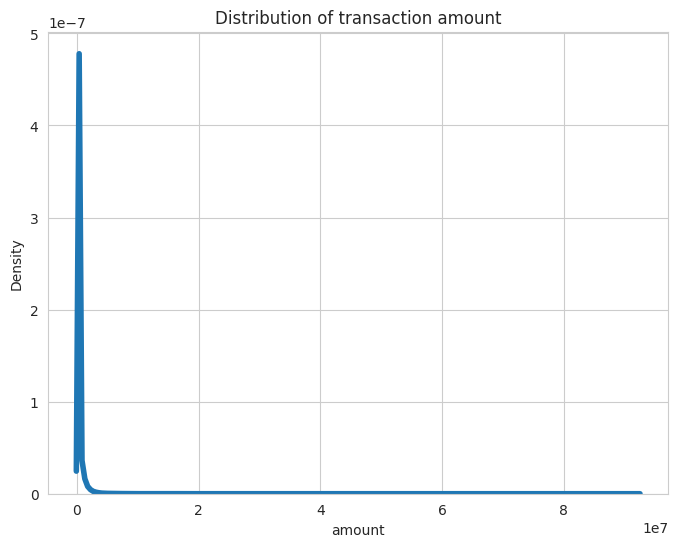

In [14]:
sns.kdeplot(df['amount'], linewidth=4)
plt.title('Distribution of transaction amount')

* The distribution of transaction amounts is right skewed.
* This indicates that most values are clustered around the left tail of the distribution, with the longer right tail.
(mode < median < mean)

In [15]:
df['nameOrig'].value_counts()

nameOrig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: count, Length: 6353307, dtype: int64

* There are 6353307 initial customers, and every step has at least 1 occurrence.

Text(0.5, 1.0, 'Distribution of transaction amount')

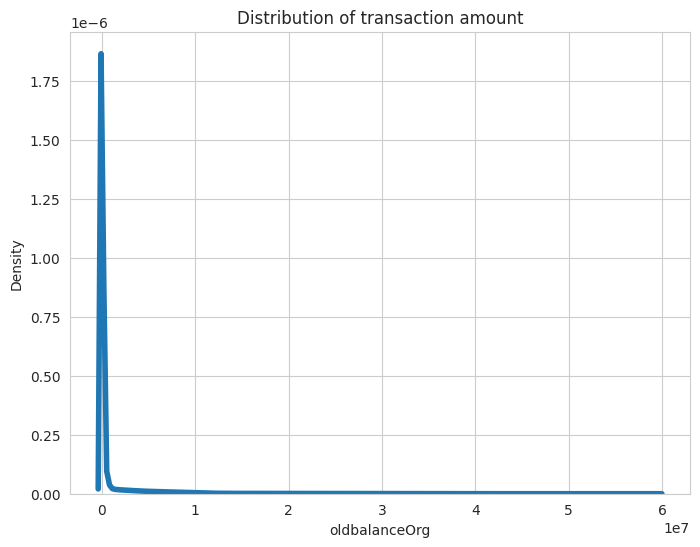

In [16]:
sns.kdeplot(df['oldbalanceOrg'], linewidth=4)
plt.title('Distribution of transaction amount')

* The distribution of pre-transaction balances of the initial customers is right skewed.

Text(0.5, 1.0, 'Distribution of transaction amount')

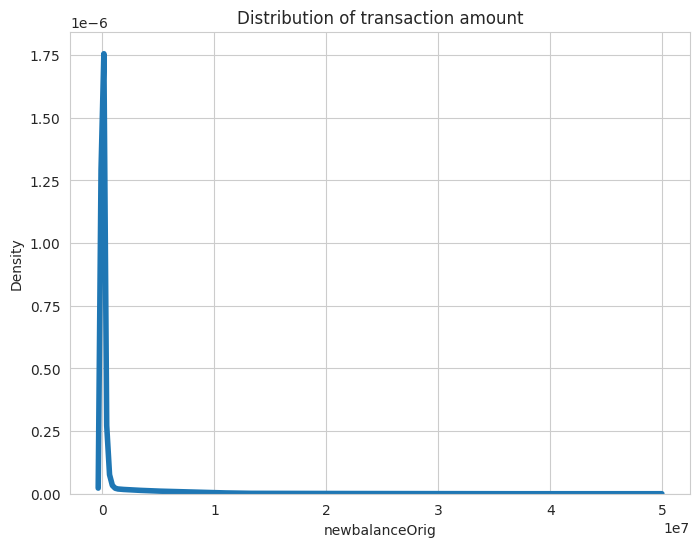

In [17]:
sns.kdeplot(df['newbalanceOrig'], linewidth=4)
plt.title('Distribution of transaction amount')

* The distribution of post-transaction balances of the initial customers is right skewed.

In [18]:
df['nameDest'].value_counts()

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: count, Length: 2722362, dtype: int64

* There are 2722362 recipients, and every step has at least 1 occurrence.

Text(0.5, 1.0, 'Distribution of transaction amount')

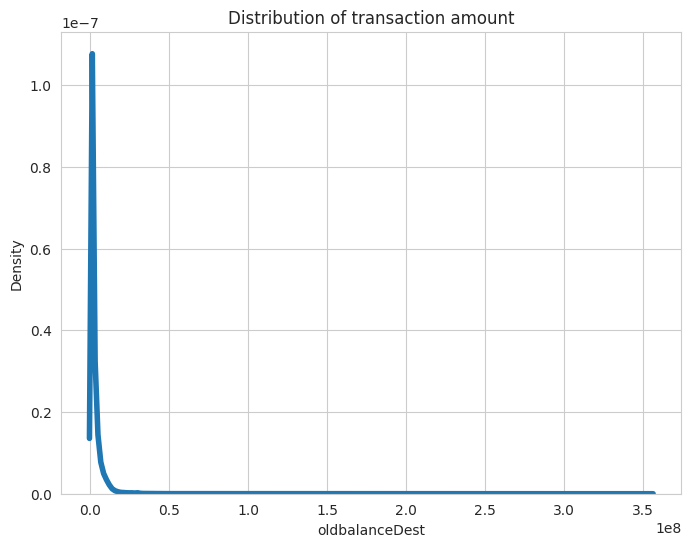

In [19]:
sns.kdeplot(df['oldbalanceDest'], linewidth=4)
plt.title('Distribution of transaction amount')

* The distribution of pre-transaction balances of the recipient is right skewed.

Text(0.5, 1.0, 'Distribution of transaction amount')

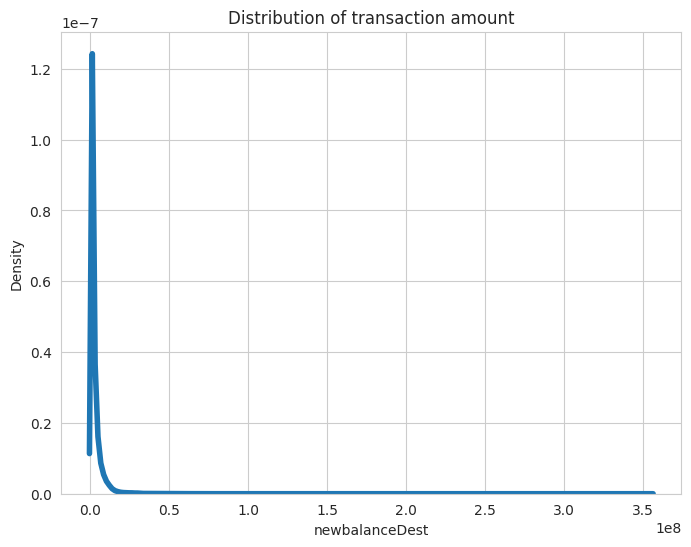

In [20]:
sns.kdeplot(df['newbalanceDest'], linewidth=4)
plt.title('Distribution of transaction amount')

* The distribution of post-transaction balances of the recipient is right skewed.

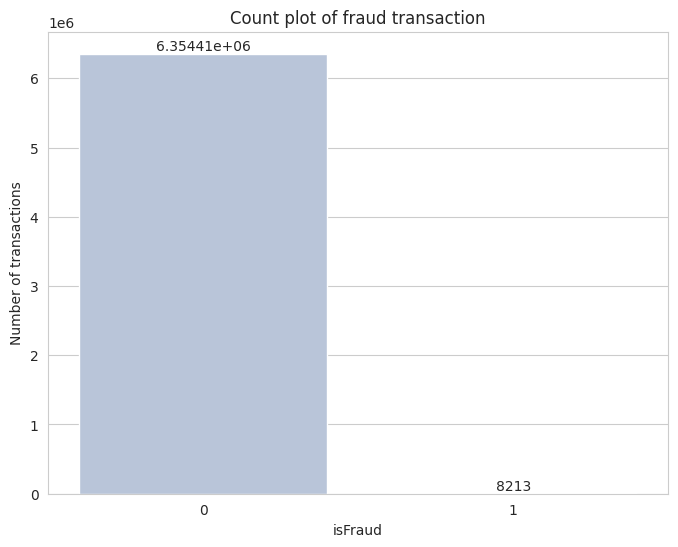

In [21]:
ax = sns.countplot(x='isFraud', data=df, palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of fraud transaction')
plt.ylabel('Number of transactions')

del ax

* There are much more non-fraudulent transactions than fraudulent transactions.

> # **Bivariate data visualization**

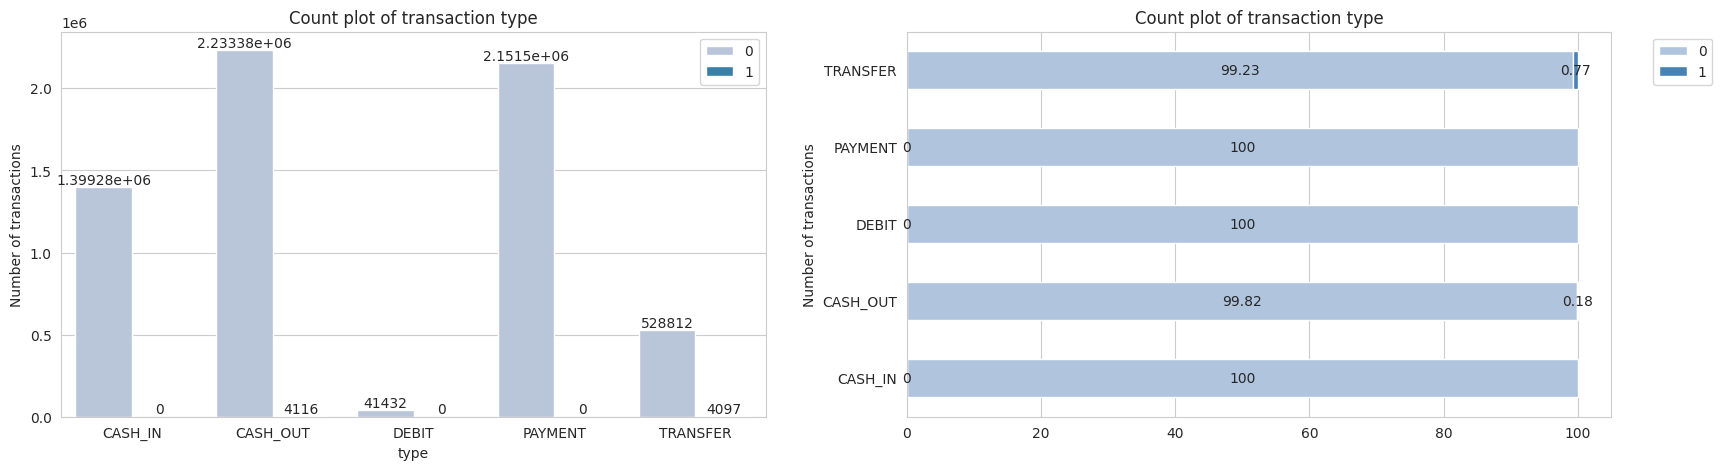

In [22]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

sns.countplot(x='type', data=df, hue='isFraud', palette='PuBu', ax=ax[0])
for container in ax[0].containers:
    ax[0].bar_label(container)
ax[0].set_title('Count plot of transaction type')
ax[0].legend(loc='best')
ax[0].set_ylabel('Number of transactions')

df2 = df.groupby(['type', 'isFraud']).size().unstack()
df2.apply(lambda x : round(x/sum(x)*100, 2), axis=1).plot(kind='barh', stacked=True, color=['lightsteelblue', 'steelblue'], ax=ax[1])
for container in ax[1].containers:
    ax[1].bar_label(container, label_type='center')
ax[1].set_title('Count plot of transaction type')
ax[1].legend(bbox_to_anchor=(1.05,1), loc='upper left')
ax[1].set_ylabel('Number of transactions')
ax[1].grid(axis='y')

* Fraudulent transactions only occur in debit and transfer types.

Text(0, 0.5, 'Number of transactions')

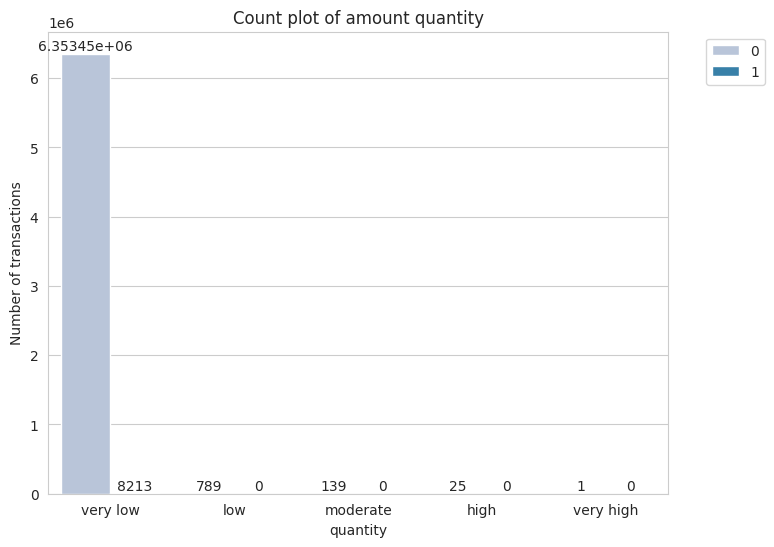

In [23]:
df['quantity'] = pd.cut(df['amount'], 5, labels=['very low', 'low', 'moderate', 'high', 'very high'])

ax = sns.countplot(x='quantity', data=df, hue='isFraud', palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of amount quantity')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')

* All fraudulent transactions fall into the category of very low amounts.
* This suggests that in most cases, small transactions are more prone to fraudulent transactions.

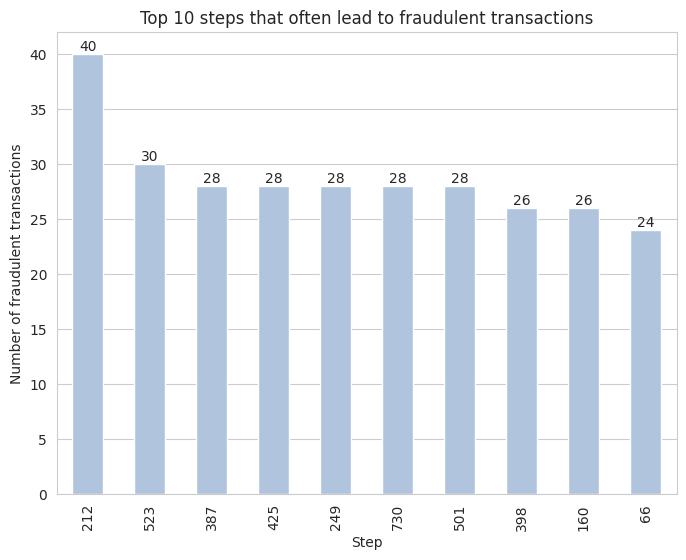

In [24]:
df1 = df[df['isFraud']==1]
df2 = df1['step'].value_counts().head(10)
ax = df2.plot(kind='bar', color='lightsteelblue')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 steps that often lead to fraudulent transactions')
plt.ylabel('Number of fraudulent transactions')
plt.xlabel('Step')
plt.grid(axis='x')

del ax, df2

* Step 212 has the highest number of fraudulent transactions, 40 cases.
* This indicates that Step 212 is the step that will most likely lead to fraudulent transactions.

Text(0.5, 0, 'Initial customers pre-transaction balance amount')

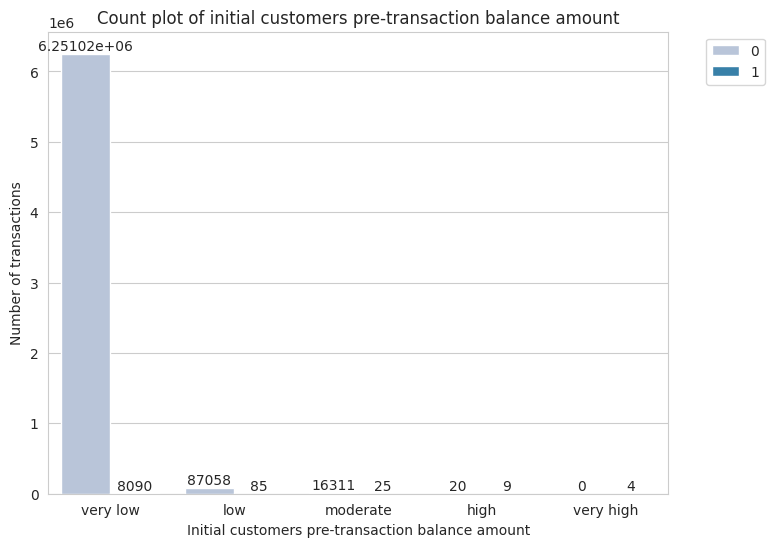

In [25]:
df['oldbalanceOrg_amt'] = pd.cut(df['oldbalanceOrg'], 5, labels=['very low', 'low', 'moderate', 'high', 'very high'])

ax = sns.countplot(x='oldbalanceOrg_amt', data=df, hue='isFraud', palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of initial customers pre-transaction balance amount')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')
plt.xlabel('Initial customers pre-transaction balance amount')

* Initial customers with very low pre-transaction balances has the highest number of fraudulent transactions.
* This means that initial customers with very low pre-transaction balances may be more likely to fall for a fraudulent transaction.

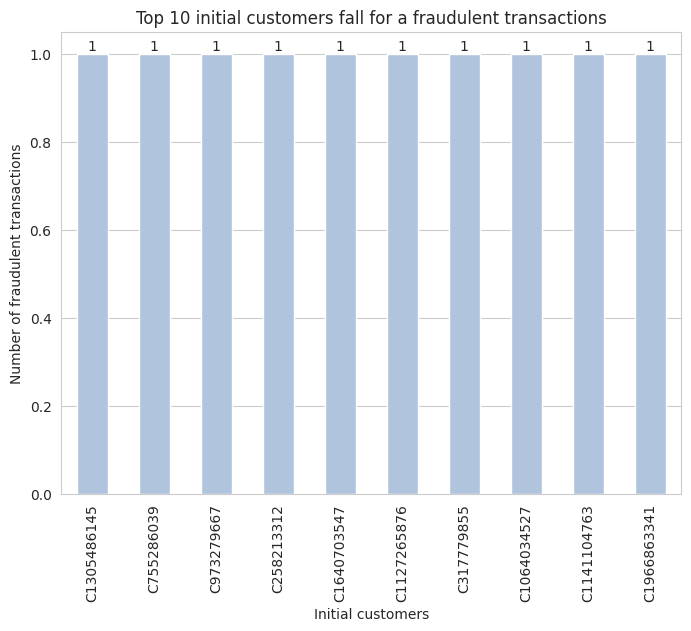

In [26]:
df2 = df1['nameOrig'].value_counts().head(10)
ax = df2.plot(kind='bar', color='lightsteelblue')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 initial customers fall for a fraudulent transactions')
plt.ylabel('Number of fraudulent transactions')
plt.xlabel('Initial customers')
plt.grid(axis='x')

del ax, df2

* Initial customers are scammed of at most one for a fraudulent transaction.

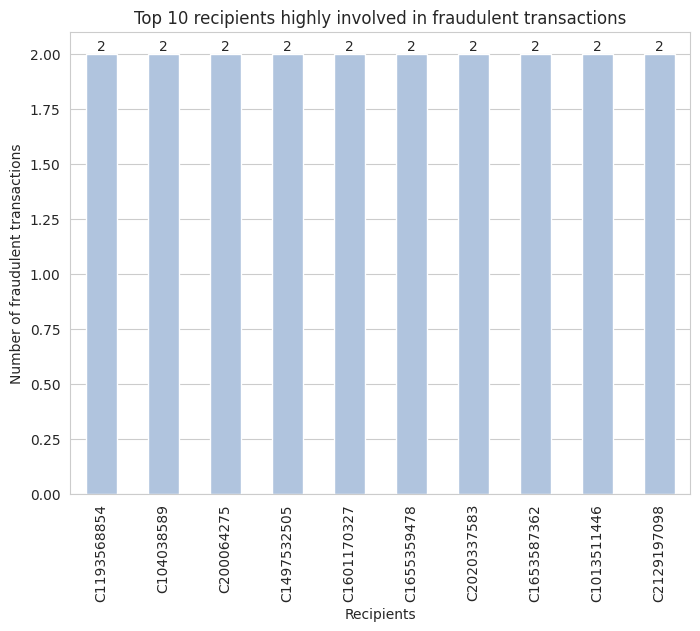

In [27]:
df2 = df1['nameDest'].value_counts().head(10)
ax = df2.plot(kind='bar', color='lightsteelblue')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 recipients highly involved in fraudulent transactions')
plt.ylabel('Number of fraudulent transactions')
plt.xlabel('Recipients')
plt.grid(axis='x')

del ax, df2

* Suspicious recipients only have a maximum of 2 involved fraudulent transactions.

Text(0.5, 0, 'Recipient pre-transaction balance amount')

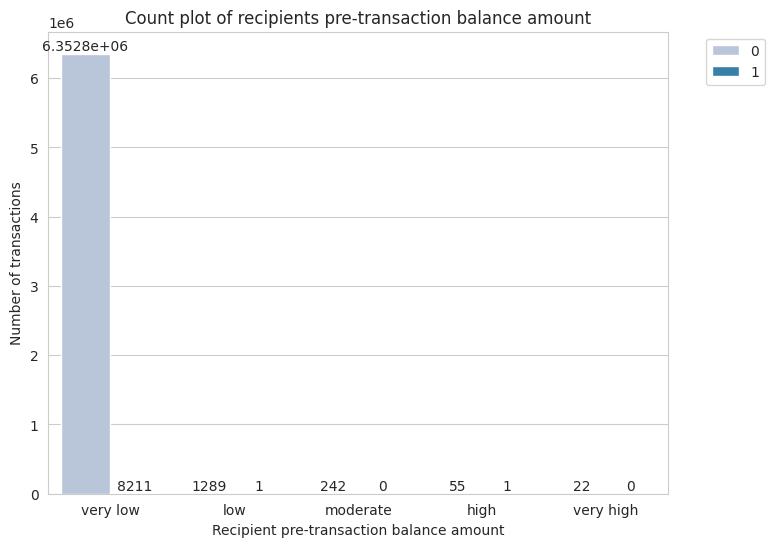

In [28]:
df['oldbalanceDest_amt'] = pd.cut(df['oldbalanceDest'], 5, labels=['very low', 'low', 'moderate', 'high', 'very high'])

ax = sns.countplot(x='oldbalanceDest_amt', data=df, hue='isFraud', palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of recipients pre-transaction balance amount')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')
plt.xlabel('Recipient pre-transaction balance amount')

* Recipients with very low pre-transaction balances has the highest number of fraudulent transactions.
* This implies that recipients with very low pre-transaction balances may be more susceptible to fraudulent transactions.

> # **Model Building**

In [29]:
# Data preprocessing
df['type'] = df['type'].map({'PAYMENT':0, 'CASH_IN':1, 'DEBIT':2, 'CASH_OUT':3, 'TRANSFER':4})

Due to the large dataset, Random Forest and Logistic Regression with balanced class weight are used to identify online payment fraud.

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_curve, auc, ConfusionMatrixDisplay


seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


X = df.copy()
X.drop(['nameOrig', 'newbalanceOrig', 'nameDest', 'newbalanceDest', 'quantity', 'oldbalanceOrg_amt', 'oldbalanceDest_amt'], axis=1, inplace=True)
y = X.pop('isFraud')


# Stratified train-test split
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train_idx, test_idx in skfold.split(X,y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


sc = StandardScaler()
scaled_train = sc.fit_transform(X_train)
scaled_test = sc.transform(X_test)
X_train = pd.DataFrame(scaled_train, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaled_test, index=X_test.index, columns=X_test.columns)


X_train, y_train = RandomUnderSampler(sampling_strategy='majority').fit_resample(X_train, y_train)

In [31]:
def model_comparison_evaluate(classifiers, X, y):
    print('K-Fold Cross-Validation:\n')
    for name, model in classifiers.items():
        print('{}:'.format(name))
        
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        
        for score in scoring:
            scores = cross_val_score(model, X, y, scoring=score, cv=skfold, n_jobs=-1)
            print('Mean {} score: {:.3f} ({:.3f})'.format(score, scores.mean(), scores.std()))
            
        print('\n')

In [32]:
classifiers = { 'Random Forest Classifier':RandomForestClassifier(class_weight='balanced', random_state=seed),
                'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=seed)
              }

In [33]:
model_comparison_evaluate(classifiers, X_train, y_train)

K-Fold Cross-Validation:

Random Forest Classifier:
Mean accuracy score: 0.985 (0.003)
Mean precision score: 0.975 (0.006)
Mean recall score: 0.996 (0.002)
Mean f1 score: 0.985 (0.003)
Mean roc_auc score: 0.998 (0.000)


Logistic Regression:
Mean accuracy score: 0.848 (0.007)
Mean precision score: 0.843 (0.008)
Mean recall score: 0.856 (0.005)
Mean f1 score: 0.849 (0.006)
Mean roc_auc score: 0.927 (0.004)




Random Forest Classifier:
               precision    recall  f1-score   support

Non-Fraud [0]       0.98      1.00      0.99   1239159
    Fraud [1]       1.00      0.05      0.09     33365

     accuracy                           0.98   1272524
    macro avg       0.99      0.52      0.54   1272524
 weighted avg       0.98      0.98      0.96   1272524
 



Text(0.5, 0, 'False Positive Rate')

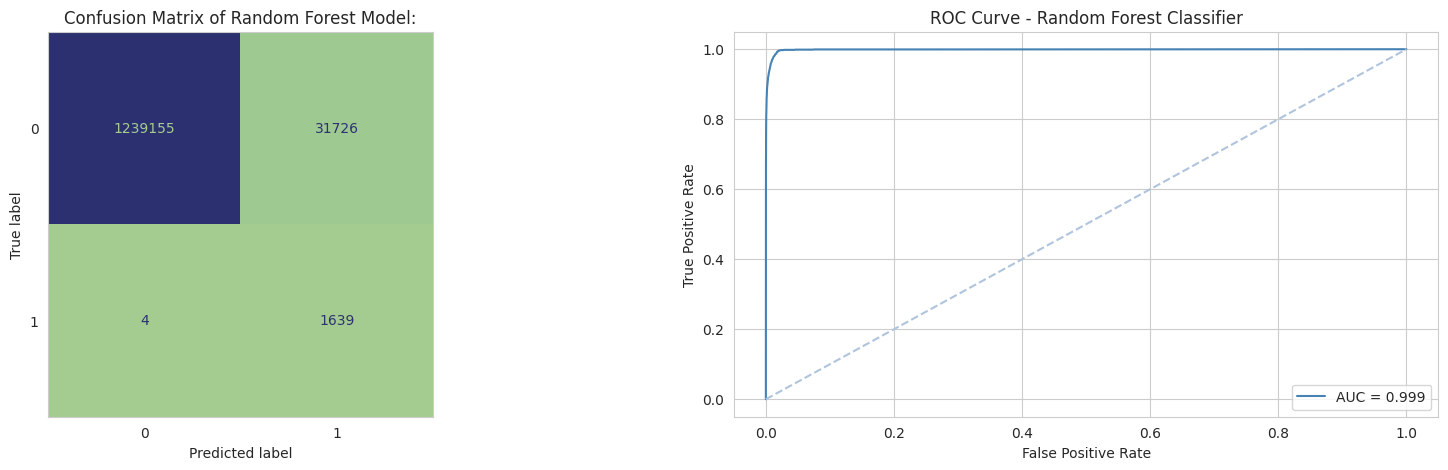

In [34]:
model = RandomForestClassifier(class_weight='balanced', random_state=seed)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_score = model.predict_proba(X_test)[:,1]
print('Random Forest Classifier:')
print(classification_report(y_pred, y_test, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']), '\n')



fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].set_title('Confusion Matrix of Random Forest Model:')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False, values_format='', cmap='crest', ax=ax[0])
ax[0].grid(False)



fpr, tpr, thresholds = roc_curve(y_test, y_pred_score)
roc_auc = auc(fpr, tpr)                       
ax[1].set_title('ROC Curve - Random Forest Classifier')
ax[1].plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc, c='steelblue')
ax[1].plot([0,1],[0,1],'--', c='lightsteelblue')
ax[1].legend(loc='lower right')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')

* From the confusion matrix, 1,239,155 were correctly classified as non-fraudulent payments, and 31,726 people were misclassified as non-fraudulent payments.
* According to the confusion matrix, 1,639 payments were incorrectly labelled as fraud while 4 payments were correctly identified as fraud.

> # **Conclusion**

* Random Forest obtains the highest score of all using K-fold cross-validation.
* The best performing model is Random Forest for identifying fraudulent and non-fraudulent payments, as the AUC is 0.999, which is close to 1. This means it has a good separability measure, and the model has an 99.9% chance of being able to distinguish between positive and negative classes.